In [1]:
import os
import warnings

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras import models
from sklearn.metrics import confusion_matrix

os.environ["KERAS_BACKEND"] = "jax"
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read the dataset


In [2]:
data_dir = "../Data/genres_original/"
classes = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

In [3]:
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []
    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--", class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(class_dir, file_name)
                try:
                    # Try to load the audio file
                    audio_data, sample_rate = librosa.load(file_path, sr=None)

                    # Performing preprocessing
                    chunk_duration = 4
                    overlap_duration = 2
                    chunk_samples = chunk_duration * sample_rate
                    overlap_samples = overlap_duration * sample_rate
                    num_chunks = (
                        int(
                            np.ceil(
                                (len(audio_data) - chunk_samples)
                                / (chunk_samples - overlap_samples)
                            )
                        )
                        + 1
                    )

                    # Iterate over each chunk
                    for i in range(num_chunks):
                        start = i * (chunk_samples - overlap_samples)
                        end = start + chunk_samples
                        chunk = audio_data[start:end]
                        mel_spectrogram = librosa.feature.melspectrogram(
                            y=chunk, sr=sample_rate
                        )

                        # Resize matrix to the target shape
                        mel_spectrogram = tf.image.resize(
                            np.expand_dims(mel_spectrogram, axis=-1), target_shape
                        )
                        data.append(mel_spectrogram)
                        labels.append(i_class)
                except Exception as e:
                    # Handle the exception and skip the corrupted file
                    print(f"Error processing file {file_path}: {e}")

    return np.array(data), np.array(labels)

In [4]:
data, labels = load_and_preprocess_data(data_dir, classes)

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Error processing file ../Data/genres_original/jazz/jazz.00054.wav: 
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [5]:
data.shape

(14975, 150, 150, 1)

In [6]:
labels.shape

(14975,)

In [7]:
len(classes)

10

In [8]:
from keras import utils

labels = utils.to_categorical(labels, num_classes=len(classes))
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11980, 150, 150, 1), (2995, 150, 150, 1), (11980, 10), (2995, 10))

## Build the model


In [11]:
from keras import layers

model = models.Sequential()

# convolutional layers parameters
conv_layers = [
    (32, 2),
    (64, 2),
    (128, 2),
    (256, 2),
    (512, 2),
]

# Input layer
model.add(
    layers.Conv2D(
        filters=conv_layers[0][0],
        kernel_size=3,
        padding="same",
        activation="relu",
        input_shape=X_train[0].shape,
    )
)

# Convolutional layers
for filters, num_layers in conv_layers:
    for _ in range(num_layers - 1):
        model.add(layers.Conv2D(filters=filters, kernel_size=3, activation="relu"))
    model.add(layers.MaxPool2D(pool_size=2, strides=2))
    if filters >= 128:
        model.add(layers.Dropout(0.3))

# Full connected layers
model.add(layers.Flatten())
model.add(layers.Dense(units=1200, activation="relu"))
model.add(layers.Dropout(0.45))
model.add(layers.Dense(units=len(classes), activation="softmax"))


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,048,058 (15.44 MB)

 Trainable params: 4,048,058 (15.44 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [14]:
from keras import callbacks

checkpoint = callbacks.ModelCheckpoint(
    "working/model_weights.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

In [ ]:
training_history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 160s 424ms/step - accuracy: 0.1666 - loss: 2.8510 - val_accuracy: 0.3199 - val_loss: 2.0814
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 165s 441ms/step - accuracy: 0.2851 - loss: 2.0118 - val_accuracy: 0.3910 - val_loss: 1.7432
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 185s 494ms/step - accuracy: 0.4015 - loss: 1.6981 - val_accuracy: 0.4758 - val_loss: 1.4766
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 174s 464ms/step - accuracy: 0.4932 - loss: 1.4603 - val_accuracy: 0.5309 - val_loss: 1.3496
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 174s 464ms/step - accuracy: 0.5304 - loss: 1.3340 - val_accuracy: 0.5870 - val_loss: 1.2044
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 173s 461ms/step - accuracy: 0.5746 - loss: 1.2316 - val_accuracy: 0.6214 - val_loss: 1.1161
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 167s 446ms/step - accuracy: 0.6060 - loss: 1.1466 - val_accuracy: 0.6384 - val_loss: 1.0352
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 167s 445ms/step - accuracy: 0.6407 -

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history.history["loss"], label="Training Loss")
plt.plot(training_history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history["accuracy"], label="Training Accuracy")
plt.plot(training_history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step


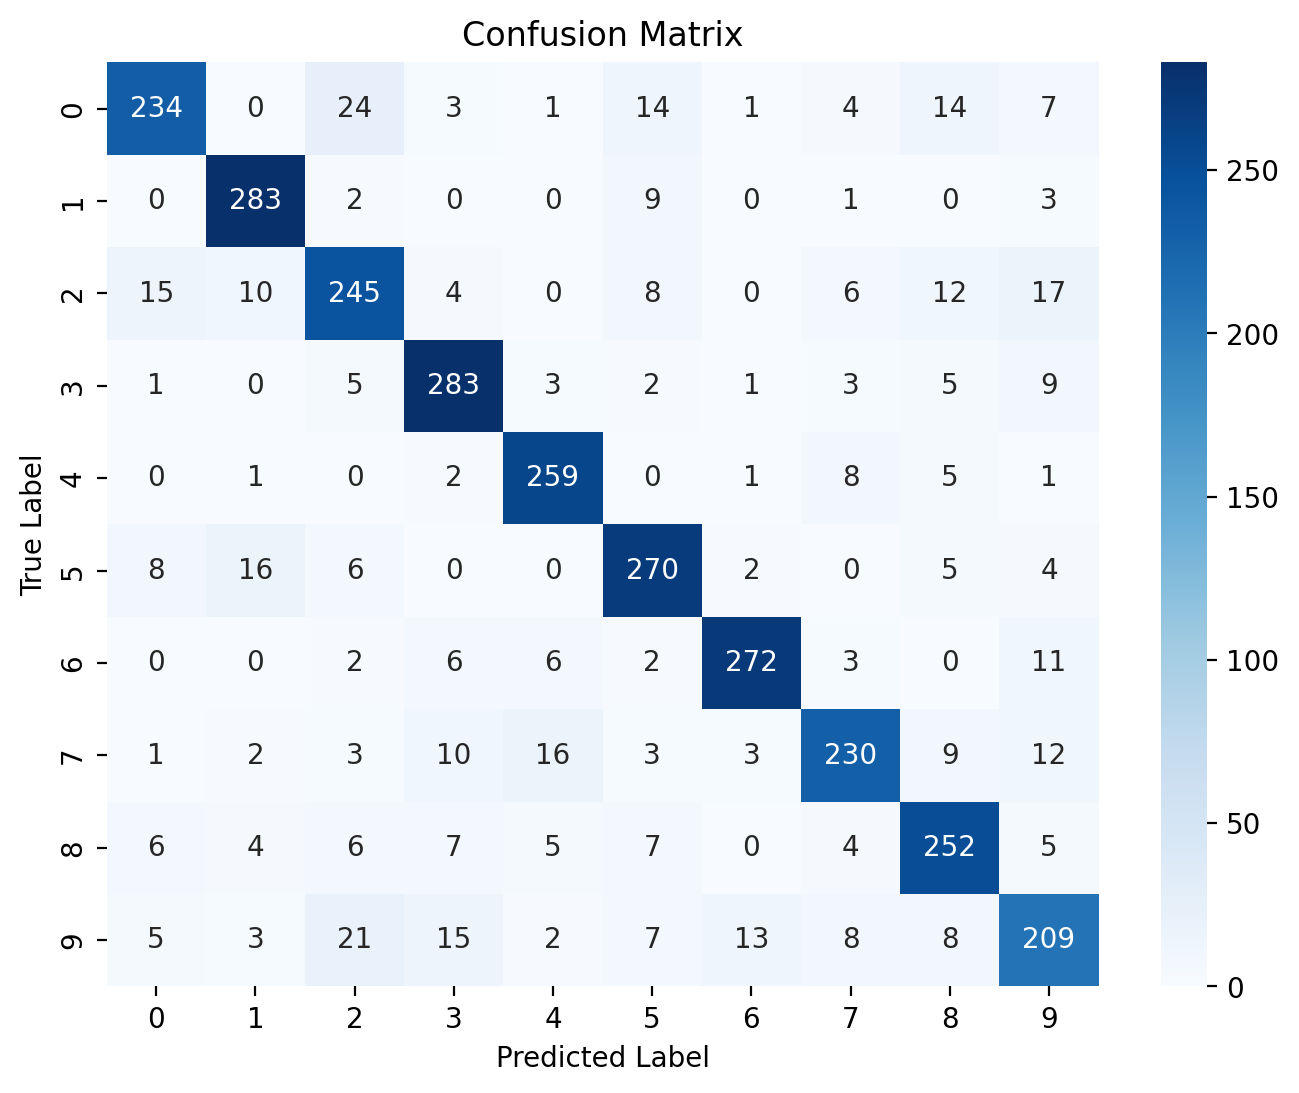

In [ ]:
model = models.load_model("working/model_weights.keras")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(len(cm)),
    yticklabels=range(len(cm)),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# save the plot
plt.savefig("../report/graphics/cnn_evaluation.pdf")
plt.show()

In [17]:
# calculate accuracy
accuracy = np.sum(y_pred_classes == y_true_classes) / len(y_true_classes)
accuracy

np.float64(0.8470784641068447)